In [1]:
import networkx as nx
from collections import defaultdict
import numpy as np

### [RQ1]
**Creating Graph**

In [2]:
DG = nx.DiGraph()

In [3]:
path = "C:/Users/Asia/"

# i.e. our_edges = {node1:[node2,node4,node5], ..., 1:[2, 3, 5], 2:[5], 3:[6] ....}
# our_edges = defaultdict(list)

with open(path + "wiki-topcats-reduced.txt", "r") as f:
    #create graph
    for line in f.readlines():
        article1, article2 = line.split()
        DG.add_weighted_edges_from([(int(article1), int(article2), 1)])
#         our_edges[int(article1)].append(int(article2))

In [4]:
# list(DG.neighbors(52))

In [5]:
# Is graph directed
print("Is graph directed? ", nx.is_directed(DG), "\n") # check whether graph is directed or not

# example;
print("Since the neighbors of 52nd node are:", *list(DG.neighbors(52)),
      ",52nd node is not neighbor for 1069112nd node which has connection with", *list(DG.neighbors(1069112))," nodes. \n")

# The number of nodes
nodes_num = DG.number_of_nodes()
print("The number of nodes:", nodes_num, "\n") # also len(DG) works

# The number of edges
edges_num = DG.number_of_edges()
print("The number of edges:", edges_num)

Is graph directed?  True 

Since the neighbors of 52nd node are: 401135 1069112 1163551 ,52nd node is not neighbor for 1069112nd node which has connection with 1060396 1061304 1062611 1066969 1069008 1069113 1069258 1069275 1656982  nodes. 

The number of nodes: 461193 

The number of edges: 2645247


**Basic Information**:
+ If it is direct or not - **Direct**
+ The number of nodes
+ The number of edges
+ The average node degree. Is the graph dense?

**Graph density**
In mathematics, a dense graph is a graph in which the number of edges is close to the maximal number of edges. The opposite, a graph with only a few edges, is a sparse graph. The distinction between sparse and dense graphs is rather vague, and depends on the context.

For directed graphs, the graph density is defined as:
$$D = \frac{|E|}{|V|(|V|-1)}$$

where E is the number of edges and V is the number of vertices in the graph. The maximum number of edges for an directed graph is $|V|(|V|-1).$

In [6]:
density = nodes_num / (edges_num*(edges_num-1))
print(density)

6.590986317548208e-08


### [RQ2] 
Given a category $C_0 = \{article_1, article_2, \dots \}$ as input we want to rank all of the nodes in V according to the block-ranking, where the blocks are represented by the categories:
$$block_{RANKING} =\begin{bmatrix} C_0 \\ C_1 \\ \dots \\ C_c\\ \end{bmatrix}$$

Each category  corresponds to a list of nodes.

The first category of the rank, $C_0$, always corresponds to the input category. The order of the remaining categories is given by:

$$distance(C_0, C_i) = median(ShortestPath(C_0, C_i))$$

The lower is the distance from $C_0$, the higher is the $C_i$ position in the rank. $ShortestPath(C_0, C_i)$ is the set of all the possible shortest paths between the nodes of $C_0$ and $C_i$. Moreover, the length of a path is given by the sum of the weights of the edges it is composed by.

##### Reading the file with categories

In [4]:
with open(path + "wiki-topcats-categories.txt", "r") as f2:
    categories = {} # {category0 : [article1, article2, ...], ...., 5: [23, 45, 6]}
    for cat_indx, line in enumerate(f2.readlines()):
        categories[cat_indx] = list(map(int, line.split(";")[1].split()))

#### Choosing categories which exist in our reduced graph:

In [5]:
tmp_selected_category_indx = []
for i in range(len(categories)):
    if len(categories[i]) > 3500:
        tmp_selected_category_indx.append(i)

selected_category_indx = []

C0 = categories[tmp_selected_category_indx[0]] #!!! Remember: we already have C0, do not create it later!

for idx in tmp_selected_category_indx[1:]:
    if len(set(categories[idx]) - set(C0)) == 0: continue
    if len(DG.subgraph(categories[idx]+C0).edges) > 0:
        selected_category_indx.append(idx)

In [6]:
len(selected_category_indx) + 1 #should be 35

34

#### Task: Find $median(ShortestPath(C0, C1))$

In [94]:
def bfs_shortest_path(graph, start, other_nodes):
    explored = []
    queue = [[start]]
    all_paths = {}
    while queue:
        path = queue.pop(0)
        node = path[-1]
        if node not in explored:
            try:
                neighbours = graph.neighbors(node)
                for neighbour in neighbours:
                    new_path = list(path)
                    new_path.append(neighbour)
                    queue.append(new_path)
                    if neighbour in other_nodes:
                        all_paths[neighbour] = len(new_path)
                explored.append(node)
            except:
                explored.append(node)
    return all_paths

In [96]:
#### creating a list with nodes for all categories apart from C0

grouped_categories_nodes = []
categories_nodes = set()
for i in range(len(selected_category_indx)):
    Ci = set(categories[selected_category_indx[i]]) - C0
    grouped_categories_nodes.append(Ci)
    categories_nodes = categories_nodes.union(Ci)

In [97]:
len(grouped_categories_nodes)

33

In [95]:
#### running bfs for all categories

import time
startingtime = time.time()
ll = len(C0)

all_distances = []
for idx, i in enumerate(C0):
    bfs_paths_dists = bfs_shortest_path(DG, i, categories_nodes)
    if bfs_paths_dists != []: 
        all_distances.extend(bfs_paths_dists.values())
        
    if idx%1000 == 0: print("Done... ", round(idx/ll, 5), " in minutes: ",  (time.time() - startingtime)/60 )
print((time.time() - startingtime)/3600, " hours")

In [ ]:
#### grouping distances per category:

grouped_categories_distances = [0] #zero is for category C0
grouped_categories_medians = [0]
for i in range(len(selected_category_indx)):
    dist_list = []
    for node in grouped_categories_nodes[i]:
        try: dist_list.append(all_distances[node])
        except KeyError: pass
    grouped_categories_distances.append(dist_list)
    grouped_categories_medians.append(np.median(dist_list))

### Paths according to networx.Dijkstry

In [36]:
set(categories[selected_category_indx[1]]) - C0

set()

In [30]:
tested_couples = [(i, j) for i in C0 for j in C1]

no_paths_list = []
path_list = []
for (i, j) in tested_couples:
    try:
        path = nx.dijkstra_path(test_graph, i, j)
        path_list.append(path)
    except:
        no_paths_list.append((i, j))

len(tested_couples)

0

--------------------------

### Plotting graph

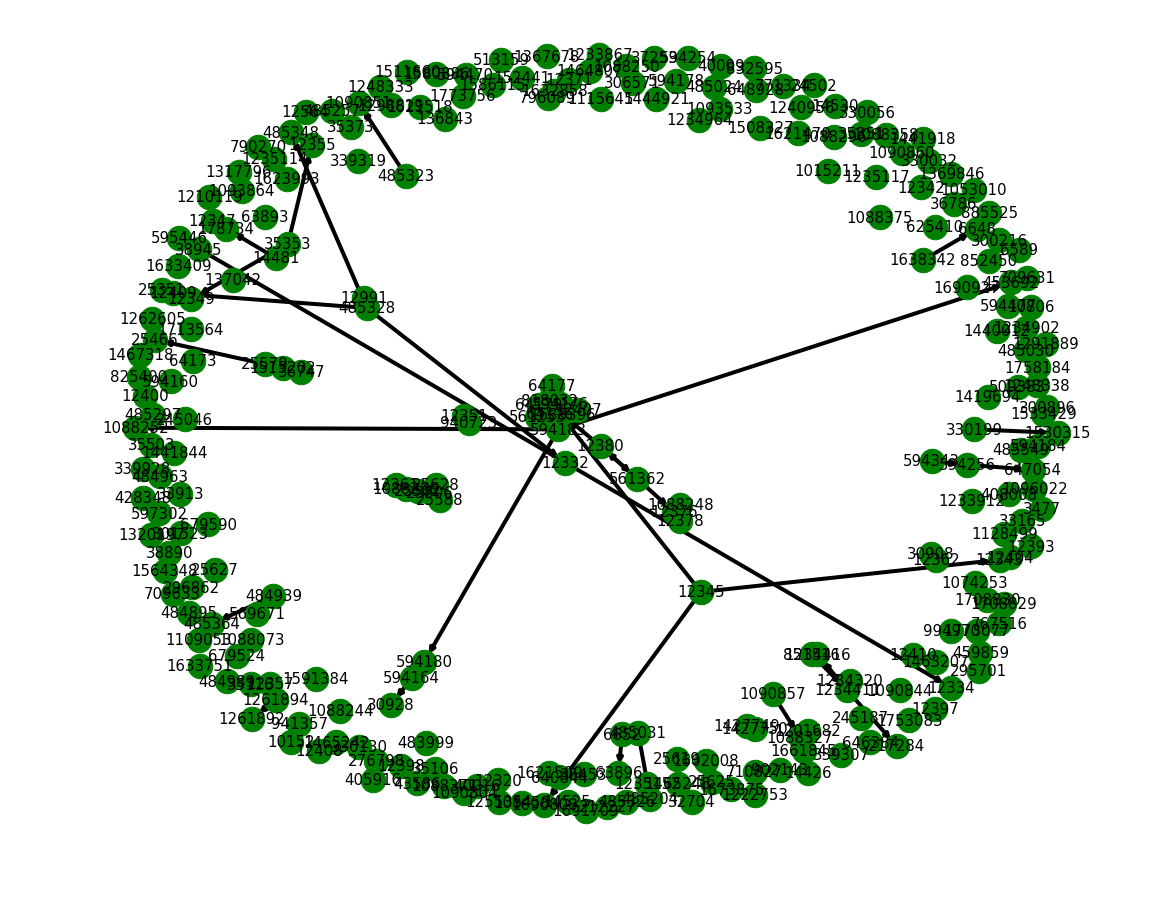

In [161]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,16))

pos = nx.spring_layout(test_graph)

# nodes 
nx.draw_networkx_nodes(test_graph, pos, node_size=600, node_color='g')

# edges
nx.draw_networkx_edges(test_graph, pos, edgelist=test_graph.edges,
                       width=4)

# labels
nx.draw_networkx_labels(test_graph, pos, font_size=15, font_family='sans-serif')

plt.axis('off')
plt.show()

--------------------

## Block Ranging Algorithm - Step 1 , 2 , 3